# 2.5 웹 검색을 지원하는 Corrective RAG

- [Corrective Retrieval Augmented Generation](https://arxiv.org/pdf/2401.15884)논문을 구현합니다
- LangGraph 공식문서에 나온 흐름을 따라갑니다
    - 공식문서의 흐름은 간소화된 버전입니다.
    - 실제 논문과 유사한 구현은 3.3강을 참고해주세요
![corrective-rag](https://i.imgur.com/IzvmbWN.png)

In [12]:
from dotenv import load_dotenv

load_dotenv()

True

In [13]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [14]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [15]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [16]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [17]:
from langchain import hub

# 허브에서 RAG 프롬프트를 가져옵니다
generate_prompt = hub.pull("rlm/rag-prompt")

# 지정된 매개변수로 언어 모델을 초기화합니다
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | generate_llm
    
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response.content}

/Users/sangjinsu/projects/inflearn-langgraph-lecture/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


- `retrieve` 노드에서 추출된 문서와 사용자의 질문이 관련이 있는지 판단합니다
    - 문서와 관련이 없다면 `rewrite` 노드로 이동해서 사용자의 질문을 변경합니다
        - `rewrite` 후 다시 `web_search` 노드로 이동해서 웹 검색을 합니다
    - 문서와 관련이 있다면 `generate` 노드로 이동해서 답변을 생성합니다

In [18]:
# set the LANGCHAIN_API_KEY environment variable (create key in settings)
from langchain import hub
from typing import Literal
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelvant']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant'를 반환합니다.
    """
    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        return 'relevant'
    
    return 'irrelvant'

/Users/sangjinsu/projects/inflearn-langgraph-lecture/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [19]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template("""사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요
질문: {query}
""")

def rewrite(state: AgentState):
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})

    return {'query': response}


- `web_search` 노드에서 웹 검색을 합니다
- `retrieve` 결과 대신 웹 검색 결과를 사용합니다
    - 웹 검색 결과는 [TavilySearchResults](https://tavily.com/) 툴을 사용합니다

In [20]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 웹 검색을 수행합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 웹 검색 결과가 추가된 state를 반환합니다.
    """
    query = state['query']
    results = tavily_search_tool.invoke(query)

    return {'context': results}

- `node`를 추가하고 `edge`로 연결합니다

In [21]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
# graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

In [22]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelvant': 'web_search'
    }
)
# graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [23]:
graph = graph_builder.compile()

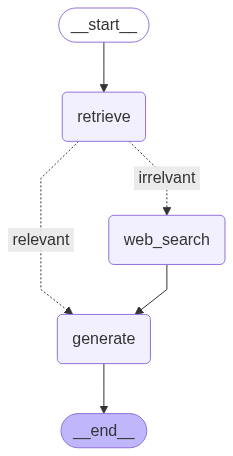

In [24]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(id='c3d95c37-2b30-4784-bfc1-51691e476b39', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 20

In [26]:
initial_state = {'query': '역삼역 맛집을 추천해주세요'}
graph.invoke(initial_state)

{'query': '역삼역 맛집을 추천해주세요',
 'context': [{'title': '역삼역 주변 맛집 리스트 - pangpang - 티스토리',
   'url': 'https://sam-repository.tistory.com/11',
   'content': "키워드:#술 #플래터 #맥주 #하이볼 #논알콜도있어요 #와인 #단체회식\n\n도로명주소:서울 강남구 테헤란로33길 18 1층\n\n맛있게 먹은 사람:76.19%(432 / 567)\n\n한 줄 평가:눈이 즐거워지는 대용량 플래터 와 인테리어가 인상적인 맥주집!\n\n맥주, 하이볼, 와인, 논알콜 다양한 종류가 있어서 주종 상관 없이 취향껏 즐길 수 있어요. 무엇보다 여러 명이서 가서 플래터를 하나 시키면 맛있고 양이 많아서 남녀노소 누구나 즐길 수 있는 술집입니다. 뿐만 아니라 인테리어, 화장실도 깔끔해서 역삼역 회식 장소로 강추!\n\n10. 신동궁감자탕 역삼직영점\n--------------------\n\nImage 12\n\n역삼역 맛집 10. 신동궁감자탕 역삼직영점\n\n키워드:#한식 #뼈숯불구이 #감자탕 #양배추샐러드도맛도리 #많이매운편 #볶음밥도필수\n\n도로명주소: 서울 강남구 테헤란로10길 21 1층\n\n맛있게 먹은 사람: 73.77%(987 / 1338) [...] 한 줄 평가:매운 음식을 좋아한다면 도전해볼만한 뼈숯불구이!\n\n매운 음식을 좋아한다면 신동궁감자탕 역삼직영점에서 매운 뼈숯불구이 를 도전해보시는 건 어떨까요? 꽤 매운 편 이라서 호불호가 갈릴 수 있으니 꼭! 매운 음식을 좋아하는 사람들이랑 가는 것을 추천드려요. 등뼈 사이사이에 낀 살이 부드럽게 발라지고, 중간중간 양배추 샐러드를 곁들여 먹거나 밥이랑 비벼 먹어도 좋아요. 다만 6시를 기준으로 사람들이 물밀 듯이 갈 수 있으니 웨이팅을 해야 할 수도 있습니다.\n\n  \n\n이상으로 역삼역 주변 맛집 리스트를 정리해보았는데요, 이번 글을 읽고 역삼역 인근의 맛집을 찾는데 도움이 되셨으면 좋겠습니다! 이상 